# Web Scraping with requests and Beautiful Soup

#### Imports Statements

In [1]:
import requests
from bs4 import BeautifulSoup as bs
from bs4 import Comment
import pandas as pd
import time

#### Get URL

In [2]:
url= 'https://www.basketball-reference.com/players/s/simshe01.html'

#### Headers to not overload systems

In [3]:
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/100.0.4896.75 Safari/537.36",
    "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8",
    "Accept-Language": "en-US,en;q=0.5",
    "Referer": "http://example.com/previous-page",
    "Cookie": "session_id=your_session_id_here",
    "Connection": "keep-alive",
    "Cache-Control": "max-age=0"
}

#### Get responses from website and return status

In [4]:
response = requests.get(url, headers=headers)
status = response.status_code

#### Return weather you were able to scrap or not

In [5]:
if status == 200:
    page = response.text
    soup = bs(page)
    print("HTML Recieved!")
    
else:
    print(f"Oops! Received status code {status}")

HTML Recieved!


#### Print HTML if obtained

In [ ]:
print(soup.prettify())

## Create Pipeline

#### Create function for getting HTML Page

In [7]:
def get_web_page(url):
    # Headers
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/100.0.4896.75 Safari/537.36",
        "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8",
        "Accept-Language": "en-US,en;q=0.5",
        "Referer": "http://example.com/previous-page",
        "Cookie": "session_id=your_session_id_here",
        "Connection": "keep-alive",
        "Cache-Control": "max-age=0"
    }
    # Response and status saved
    response = requests.get(url, headers=headers)
    status = response.status_code
    
    # Return if HTML obtained
    if status == 200:
        return response.text
    else:
        print(f"Oops! Received status code {status}")
        return ""

#### Get URLS and pipline list ready

In [8]:
# URl
base = "https://www.basketball-reference.com"
url_start = f"{base}/players/"

# List of Info
pipeline_list = []

#### Get HTML and soup

In [9]:
html = get_web_page(url_start)
soup = bs(html, "html.parser")

#### Find hidden tags within HTML Comments and only keeps URL linked comments *--Used Help from ChatGPT*

In [10]:
# Finds all comments in HTML
comments = soup.find_all(string=lambda text: isinstance(text, Comment))

# Empty List
letter_links = []

# Loop through comments to only keep the ones with URLS and remove the rest
for c in comments:
    if '/players/' in c:
        comment_soup = bs(c, "html.parser")
        for a in comment_soup.select("a[href^='/players/']"):
            href = a.get("href")
            if href and len(href) == 11:
                letter_links.append(base + href)

# Print links found
print(f"Found {len(letter_links)} letter pages.")

Found 25 letter pages.


C:\ProgramData\Anaconda3\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


#### Gather all Player Links

In [11]:
# Empty List
player_links = []

# loop through links and get pages
for letter_url in letter_links:
    page = get_web_page(letter_url)
    soup = bs(page, "html.parser")

    # Get each player table
    for a in soup.select("th[data-stat='player'] a"):
        href = a.get("href")
        # Add url to player link
        if href:
            player_links.append(base + href)
    time.sleep(1)

# print
print(f"Collected {len(player_links)} player profile links.")

Collected 5372 player profile links.


#### Loop through 5 players and scrape each part of their stats

In [12]:
# Loop through first 5 players
for i, url in enumerate(player_links[:5]):
    
    # Get the HTML and soup of the player
    html = get_web_page(url)
    soup = bs(html, "html.parser")

    # Get name
    name = soup.find("h1").find("span").text.strip() if soup.find("h1") else "N/A"

    # Get p tags
    position_tag = soup.find("p")
    p_tags = soup.find_all("p")
    position = "N/A"
    weight = None

    # Converts each paragraph into text
    for p in p_tags:
        text = p.get_text(" ", strip=True)
    
        # Look for the Position
        if "Position:" in text:
            # Extract the position value only *got help from chatGPT
            position = (
                text.split("Position:")[1]
                .split("Shoots:")[0]
                .split("▪")[0]
                .strip()
            )
    
        # Look for the Weight
        if "lb" in text:
            spans = p.find_all("span")
            if len(spans) > 1:
                # Extract the weight value only
                weight_text = spans[1].text.strip()
                if "lb" in weight_text:
                    weight = int(weight_text.replace("lb", "").strip())


        # mp_per_g tag
        minute_tags = soup.find_all("td", {"data-stat": "mp_per_g"})
        # extract and convert to float
        minutes_played = [float(tag.text.strip()) for tag in minute_tags if tag.text.strip()]

        # pts_per_g tag
        ppg_tags = soup.find_all("td", {"data-stat": "pts_per_g"})
        # extract and convert to float
        points_per_game = [float(tag.text.strip()) for tag in ppg_tags if tag.text.strip()]
          
        # fta_per_g tag
        fta_tags = soup.find_all("td", {"data-stat": "fta_per_g"})
        # Create empty list
        free_throws = []
        # Loop throuhg the tag and add values to list * got help from chatGPT
        for tag in fta_tags:
            text = tag.text.strip()
            if text:  # skip empty cells
                try:
                    free_throws.append(float(text))
                except ValueError:
                    pass  # ignore non-numeric text
        # if no values resort to 0
        if not free_throws:
            free_throws = [0]

        # blk_per_g tag
        blk_tags = soup.find_all("td", {"data-stat": "blk_per_g"})
        # extract and convert to float *got help from chatGPT
        blocks = float(blk_tags[-1].text.strip()) if blk_tags and blk_tags[-1].text.strip() else 0
        
        # games total
        total_games = 0
        games_label = soup.find("span", {"class": "poptip", "data-tip": "Games"})
        if games_label:
            # find the p tag and get the total game
            p_tag = games_label.find_next("p").find_next("p")
            if p_tag and p_tag.text.strip().isdigit():
                total_games = int(p_tag.text.strip())

        # Create a big dictionary for each player with their corresponding stats
        player_dict = {
        "name": name,
        "position": position,
        "weight": weight,
        "minutes played": minutes_played,
        "points": points_per_game,
        "free_throws": free_throws,
        "blocks": blocks,
        "total_games": total_games
        }
        
    # Add to pipeline list
    pipeline_list.append(player_dict)
    if i % 1 == 0:
        print(f"Processed {i+1}/{len(player_links)} players...")
    
    # sleep between requests
    time.sleep(2)
print(f"\nTotal players scraped: {len(pipeline_list)}")
print(pipeline_list[:5])

Processed 1/5372 players...
Processed 2/5372 players...
Processed 3/5372 players...
Processed 4/5372 players...
Processed 5/5372 players...

Total players scraped: 5
[{'name': 'Alaa Abdelnaby', 'position': 'Power Forward', 'weight': 240, 'minutes played': [6.7, 13.2, 17.5, 13.3, 18.3, 12.2, 9.4, 9.3, 10.0, 12.5, 10.7, 17.3, 9.3, 13.3, 10.0, 2.6, 3.1, 17.0, 6.2, 2.9, 17.0], 'points': [3.1, 6.1, 7.7, 5.3, 8.2, 4.9, 4.7, 5.0, 0.7, 5.7, 5.0, 7.6, 5.0, 5.3, 0.7, 0.8, 1.5, 5.5, 2.2, 1.2, 5.5], 'free_throws': [1.0, 1.4, 1.5, 1.3, 1.6, 1.9, 0.6, 0.7, 0.0, 1.3, 1.3, 1.6, 0.7, 1.3, 0.0, 0.0, 0.5, 0.0, 0.2, 0.3, 0.0], 'blocks': 0.3, 'total_games': 256}, {'name': 'Zaid Abdul-Aziz', 'position': 'Center and Power Forward', 'weight': 235, 'minutes played': [19.3, 5.4, 28.9, 20.5, 20.9, 30.7, 18.8, 31.1, 22.3, 8.3, 8.9, 9.9, 12.0, 9.6, 21.8, 24.0, 22.5, 22.7, 8.9, 5.4, 12.0, 11.7, 11.3, 12.0, 11.7, 11.7, 11.3, 12.0], 'points': [7.3, 1.9, 11.0, 7.4, 10.9, 13.8, 8.7, 10.9, 9.7, 3.2, 3.8, 3.9, 4.0, 3.9, 

#### Start to move data to pandas df

In [13]:
# Convert player dictionaries to df
df = pd.DataFrame(pipeline_list)

# standardize column
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

#### Get averages for mp p ft and b

In [14]:
for col, new_col in [
    ("minutes_played", "avg_minutes"),
    ("points", "avg_points"),
    ("free_throws", "avg_free_throws"),
    ("blocks", "avg_blocks")]:
    # get average * help from chatGPT
    if col in df.columns:
        df[new_col] = df[col].apply(
            lambda x: round(sum(x)/len(x), 1) if isinstance(x, list) and len(x) > 0
            else round(float(x), 1) if x is not None else 0
        )
    # if nothing return 0
    else:
        df[new_col] = 0

In [15]:
# Drop unnecessary columns
for col in ["minutes_played", "points", "free_throws", "blocks"]:
    if col in df.columns:
        df.drop(columns=[col], inplace=True)

# Convert to numeric (int/float)
numeric_cols = ["weight", "avg_minutes", "avg_points", "avg_free_throws", "avg_blocks", "total_games"]
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce').fillna(0)

# Clean string columns
df[["name", "position"]] = df[["name", "position"]].apply(lambda x: x.str.strip())

# Reorder columns
cols_order = ["name", "position", "weight", "avg_minutes", "avg_points", "avg_free_throws", "avg_blocks", "total_games"]
df = df[cols_order]

# Display cleaned DataFrame
df.head()


,name,position,weight,avg_minutes,avg_points,avg_free_throws,avg_blocks,total_games
0,Alaa Abdelnaby,Power Forward,240,11.0,4.4,0.8,0.3,256
1,Zaid Abdul-Aziz,Center and Power Forward,235,15.9,6.6,2.1,1.0,505
2,Kareem Abdul-Jabbar,Center,225,38.0,25.1,6.1,2.4,1560
3,Mahmoud Abdul-Rauf,Point Guard,162,25.2,13.3,2.1,0.1,586
4,Tariq Abdul-Wahad,Shooting Guard,223,18.2,6.7,2.0,0.8,236


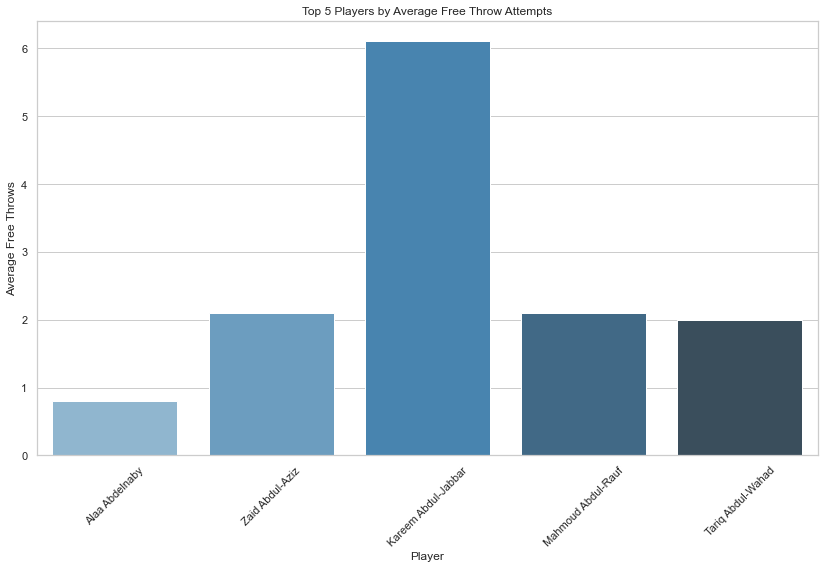

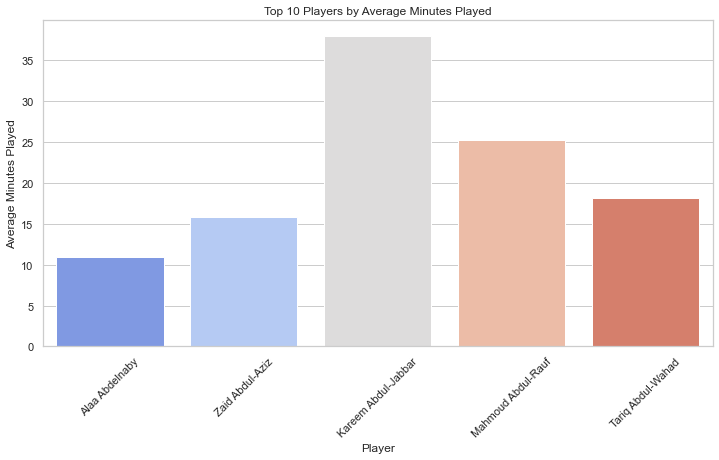

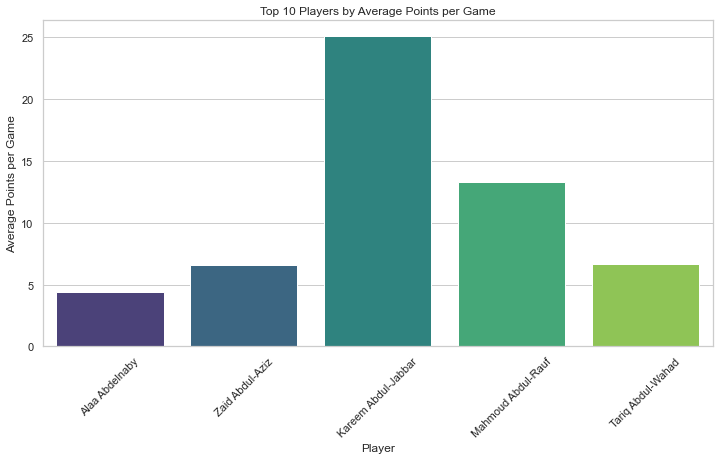

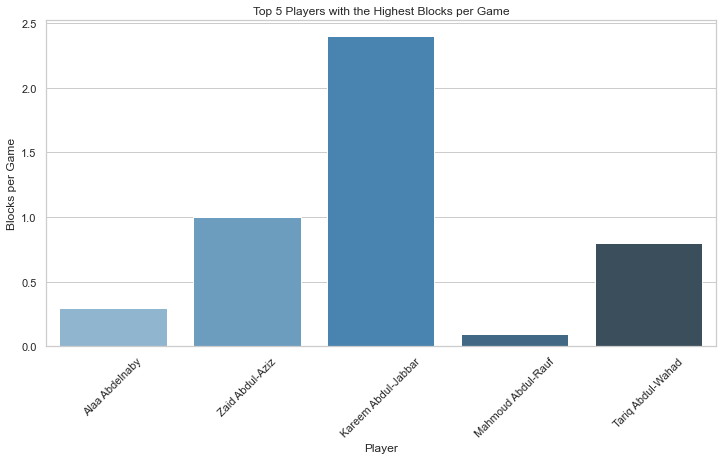

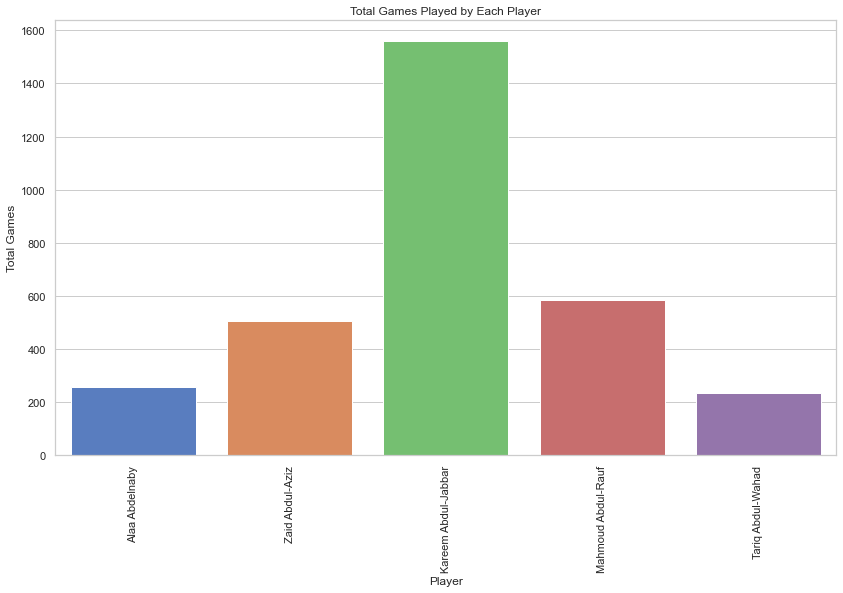

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is the cleaned DataFrame

# Set the style for Seaborn (optional, you can customize the style)
sns.set(style="whitegrid")

# --- Question 1: Average Free Throw Attempts for the Players ---
# Plot top 10 players based on avg_free_throws
# Plot top 5 players based on avg_free_throws
plt.figure(figsize=(14, 8))
sns.barplot(x='name', y='avg_free_throws', data=df, palette="Blues_d")
plt.title("Top 5 Players by Average Free Throw Attempts")
plt.xlabel("Player")
plt.ylabel("Average Free Throws")
plt.xticks(rotation=45)
plt.show()


# --- Question 2: Top Players with the Highest Total Minutes Played ---
# Plot top 10 players based on avg_minutes
plt.figure(figsize=(12, 6))
sns.barplot(x='name', y='avg_minutes', data=df, palette="coolwarm")
plt.title("Top 10 Players by Average Minutes Played")
plt.xlabel("Player")
plt.ylabel("Average Minutes Played")
plt.xticks(rotation=45)
plt.show()

# --- Question 3: Top Players with the Highest Points per Game ---
# Plot top 10 players based on avg_points
plt.figure(figsize=(12, 6))
sns.barplot(x='name', y='avg_points', data=df, palette="viridis")
plt.title("Top 10 Players by Average Points per Game")
plt.xlabel("Player")
plt.ylabel("Average Points per Game")
plt.xticks(rotation=45)
plt.show()

# --- Question 4: Top 5 Players with the Highest Blocks ---
# Plot top 5 players based on avg_blocks
top_blocks = df.nlargest(5, 'avg_blocks')[['name', 'avg_blocks']]
plt.figure(figsize=(12, 6))
sns.barplot(x='name', y='avg_blocks', data=df, palette="Blues_d")
plt.title("Top 5 Players with the Highest Blocks per Game")
plt.xlabel("Player")
plt.ylabel("Blocks per Game")
plt.xticks(rotation=45)
plt.show()

# --- Question 5: Total Games Played by Each Player ---
# Plot total games for all players
plt.figure(figsize=(14, 8))
sns.barplot(x='name', y='total_games', data=df, palette="muted")
plt.title("Total Games Played by Each Player")
plt.xlabel("Player")
plt.ylabel("Total Games")
plt.xticks(rotation=90)
plt.show()
